# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.8221
Epoch 1/200, Iteration 2/12, Loss: 0.9834
Epoch 1/200, Iteration 3/12, Loss: 0.8710
Epoch 1/200, Iteration 4/12, Loss: 0.3957
Epoch 1/200, Iteration 5/12, Loss: 0.4208
Epoch 1/200, Iteration 6/12, Loss: 0.5934
Epoch 1/200, Iteration 7/12, Loss: 0.5057
Epoch 1/200, Iteration 8/12, Loss: 0.3803
Epoch 1/200, Iteration 9/12, Loss: 0.3550
Epoch 1/200, Iteration 10/12, Loss: 0.3393
Epoch 1/200, Iteration 11/12, Loss: 0.3260
Epoch 1/200, Iteration 12/12, Loss: 0.3385
Epoch 1/200, Iteration 13/12, Loss: 0.3308
Train Error: 
 Accuracy: 56.5%, Avg loss: 0.310081, MRE: 0.300325, MAE: 0.037436 

Test Error: 
 Accuracy: 63.0%, Avg loss: 0.305427, MRE: 0.254652, MAE: 0.035726 

Epoch 2/200, Iteration 1/12, Loss: 0.2899
Epoch 2/200, Iteration 2/12, Loss: 0.2791
Epoch 2/200, Iteration 3/12, Loss: 0.2821
Epoch 2/200, Iteration 4/12, Loss: 0.2393
Epoch 2/200, Iteration 5/12, Loss: 0.2699
Epoch 2/200, Iteration 6/12, Loss: 0.2414
Epoch 2/200, Iteration 7/12, Loss

Train Error: 
 Accuracy: 78.88%, Avg loss: 0.087478, MRE: 0.075969, MAE: 0.012153 

Test Error: 
 Accuracy: 76.5%, Avg loss: 0.088029, MRE: 0.065069, MAE: 0.012445 

Epoch 13/200, Iteration 1/12, Loss: 0.0871
Epoch 13/200, Iteration 2/12, Loss: 0.0968
Epoch 13/200, Iteration 3/12, Loss: 0.0813
Epoch 13/200, Iteration 4/12, Loss: 0.0977
Epoch 13/200, Iteration 5/12, Loss: 0.0664
Epoch 13/200, Iteration 6/12, Loss: 0.0903
Epoch 13/200, Iteration 7/12, Loss: 0.0882
Epoch 13/200, Iteration 8/12, Loss: 0.0995
Epoch 13/200, Iteration 9/12, Loss: 0.1098
Epoch 13/200, Iteration 10/12, Loss: 0.0884
Epoch 13/200, Iteration 11/12, Loss: 0.0834
Epoch 13/200, Iteration 12/12, Loss: 0.0970
Epoch 13/200, Iteration 13/12, Loss: 0.0909
Train Error: 
 Accuracy: 96.25%, Avg loss: 0.119646, MRE: 0.076447, MAE: 0.014061 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.115815, MRE: 0.066846, MAE: 0.013581 

Epoch 14/200, Iteration 1/12, Loss: 0.1069
Epoch 14/200, Iteration 2/12, Loss: 0.1054
Epoch 14/200, Itera

Train Error: 
 Accuracy: 53.12%, Avg loss: 0.095411, MRE: 0.090344, MAE: 0.011317 

Test Error: 
 Accuracy: 56.0%, Avg loss: 0.097152, MRE: 0.077783, MAE: 0.011551 

Epoch 25/200, Iteration 1/12, Loss: 0.0969
Epoch 25/200, Iteration 2/12, Loss: 0.1215
Epoch 25/200, Iteration 3/12, Loss: 0.1193
Epoch 25/200, Iteration 4/12, Loss: 0.0692
Epoch 25/200, Iteration 5/12, Loss: 0.1146
Epoch 25/200, Iteration 6/12, Loss: 0.1233
Epoch 25/200, Iteration 7/12, Loss: 0.1153
Epoch 25/200, Iteration 8/12, Loss: 0.1272
Epoch 25/200, Iteration 9/12, Loss: 0.0899
Epoch 25/200, Iteration 10/12, Loss: 0.1305
Epoch 25/200, Iteration 11/12, Loss: 0.1245
Epoch 25/200, Iteration 12/12, Loss: 0.0812
Epoch 25/200, Iteration 13/12, Loss: 0.1213
Train Error: 
 Accuracy: 51.5%, Avg loss: 0.141055, MRE: 0.124905, MAE: 0.019608 

Test Error: 
 Accuracy: 54.0%, Avg loss: 0.126682, MRE: 0.099070, MAE: 0.018067 

Epoch 26/200, Iteration 1/12, Loss: 0.1371
Epoch 26/200, Iteration 2/12, Loss: 0.1295
Epoch 26/200, Iterat

Train Error: 
 Accuracy: 98.62%, Avg loss: 0.013926, MRE: 0.016643, MAE: 0.001795 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.014523, MRE: 0.011646, MAE: 0.001871 

Epoch 37/200, Iteration 1/12, Loss: 0.0106
Epoch 37/200, Iteration 2/12, Loss: 0.0194
Epoch 37/200, Iteration 3/12, Loss: 0.0214
Epoch 37/200, Iteration 4/12, Loss: 0.0177
Epoch 37/200, Iteration 5/12, Loss: 0.0181
Epoch 37/200, Iteration 6/12, Loss: 0.0192
Epoch 37/200, Iteration 7/12, Loss: 0.0144
Epoch 37/200, Iteration 8/12, Loss: 0.0171
Epoch 37/200, Iteration 9/12, Loss: 0.0178
Epoch 37/200, Iteration 10/12, Loss: 0.0218
Epoch 37/200, Iteration 11/12, Loss: 0.0134
Epoch 37/200, Iteration 12/12, Loss: 0.0122
Epoch 37/200, Iteration 13/12, Loss: 0.0201
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.014457, MRE: 0.017132, MAE: 0.001844 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.014759, MRE: 0.012545, MAE: 0.001840 

Epoch 38/200, Iteration 1/12, Loss: 0.0165
Epoch 38/200, Iteration 2/12, Loss: 0.0148
Epoch 38/200, Itera

Train Error: 
 Accuracy: 98.88%, Avg loss: 0.013965, MRE: 0.013872, MAE: 0.001737 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.013157, MRE: 0.009828, MAE: 0.001657 

Epoch 49/200, Iteration 1/12, Loss: 0.0148
Epoch 49/200, Iteration 2/12, Loss: 0.0105
Epoch 49/200, Iteration 3/12, Loss: 0.0152
Epoch 49/200, Iteration 4/12, Loss: 0.0135
Epoch 49/200, Iteration 5/12, Loss: 0.0138
Epoch 49/200, Iteration 6/12, Loss: 0.0153
Epoch 49/200, Iteration 7/12, Loss: 0.0161
Epoch 49/200, Iteration 8/12, Loss: 0.0215
Epoch 49/200, Iteration 9/12, Loss: 0.0141
Epoch 49/200, Iteration 10/12, Loss: 0.0227
Epoch 49/200, Iteration 11/12, Loss: 0.0161
Epoch 49/200, Iteration 12/12, Loss: 0.0177
Epoch 49/200, Iteration 13/12, Loss: 0.0194
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.019597, MRE: 0.017451, MAE: 0.002390 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.018288, MRE: 0.012710, MAE: 0.002284 

Epoch 50/200, Iteration 1/12, Loss: 0.0164
Epoch 50/200, Iteration 2/12, Loss: 0.0235
Epoch 50/200, Itera

Train Error: 
 Accuracy: 99.25%, Avg loss: 0.013478, MRE: 0.014265, MAE: 0.001838 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.012633, MRE: 0.010101, MAE: 0.001682 

Epoch 61/200, Iteration 1/12, Loss: 0.0131
Epoch 61/200, Iteration 2/12, Loss: 0.0128
Epoch 61/200, Iteration 3/12, Loss: 0.0135
Epoch 61/200, Iteration 4/12, Loss: 0.0106
Epoch 61/200, Iteration 5/12, Loss: 0.0118
Epoch 61/200, Iteration 6/12, Loss: 0.0073
Epoch 61/200, Iteration 7/12, Loss: 0.0145
Epoch 61/200, Iteration 8/12, Loss: 0.0182
Epoch 61/200, Iteration 9/12, Loss: 0.0105
Epoch 61/200, Iteration 10/12, Loss: 0.0098
Epoch 61/200, Iteration 11/12, Loss: 0.0135
Epoch 61/200, Iteration 12/12, Loss: 0.0188
Epoch 61/200, Iteration 13/12, Loss: 0.0130
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.016927, MRE: 0.015500, MAE: 0.002145 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016174, MRE: 0.012260, MAE: 0.002019 

Epoch 62/200, Iteration 1/12, Loss: 0.0171
Epoch 62/200, Iteration 2/12, Loss: 0.0136
Epoch 62/200, Iterat

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.012470, MRE: 0.010862, MAE: 0.001772 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.011858, MRE: 0.008199, MAE: 0.001668 

Epoch 73/200, Iteration 1/12, Loss: 0.0121
Epoch 73/200, Iteration 2/12, Loss: 0.0161
Epoch 73/200, Iteration 3/12, Loss: 0.0099
Epoch 73/200, Iteration 4/12, Loss: 0.0136
Epoch 73/200, Iteration 5/12, Loss: 0.0112
Epoch 73/200, Iteration 6/12, Loss: 0.0124
Epoch 73/200, Iteration 7/12, Loss: 0.0164
Epoch 73/200, Iteration 8/12, Loss: 0.0110
Epoch 73/200, Iteration 9/12, Loss: 0.0121
Epoch 73/200, Iteration 10/12, Loss: 0.0136
Epoch 73/200, Iteration 11/12, Loss: 0.0102
Epoch 73/200, Iteration 12/12, Loss: 0.0141
Epoch 73/200, Iteration 13/12, Loss: 0.0131
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.011161, MRE: 0.010624, MAE: 0.001462 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.010500, MRE: 0.008568, MAE: 0.001385 

Epoch 74/200, Iteration 1/12, Loss: 0.0099
Epoch 74/200, Iteration 2/12, Loss: 0.0168
Epoch 74/200, Itera

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008556, MRE: 0.006608, MAE: 0.001125 

Epoch 85/200, Iteration 1/12, Loss: 0.0116
Epoch 85/200, Iteration 2/12, Loss: 0.0066
Epoch 85/200, Iteration 3/12, Loss: 0.0112
Epoch 85/200, Iteration 4/12, Loss: 0.0102
Epoch 85/200, Iteration 5/12, Loss: 0.0102
Epoch 85/200, Iteration 6/12, Loss: 0.0089
Epoch 85/200, Iteration 7/12, Loss: 0.0079
Epoch 85/200, Iteration 8/12, Loss: 0.0095
Epoch 85/200, Iteration 9/12, Loss: 0.0107
Epoch 85/200, Iteration 10/12, Loss: 0.0091
Epoch 85/200, Iteration 11/12, Loss: 0.0111
Epoch 85/200, Iteration 12/12, Loss: 0.0114
Epoch 85/200, Iteration 13/12, Loss: 0.0097
Train Error: 
 Accuracy: 99.38%, Avg loss: 0.010740, MRE: 0.009950, MAE: 0.001390 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.010095, MRE: 0.007805, MAE: 0.001299 

Epoch 86/200, Iteration 1/12, Loss: 0.0136
Epoch 86/200, Iteration 2/12, Loss: 0.0103
Epoch 86/200, Iteration 3/12, Loss: 0.0094
Epoch 86/200, Iteration 4/12, Loss: 0.0109
Epoch 86/200, Ite

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.008396, MRE: 0.009158, MAE: 0.001090 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.008099, MRE: 0.006774, MAE: 0.001057 

Epoch 97/200, Iteration 1/12, Loss: 0.0103
Epoch 97/200, Iteration 2/12, Loss: 0.0069
Epoch 97/200, Iteration 3/12, Loss: 0.0090
Epoch 97/200, Iteration 4/12, Loss: 0.0047
Epoch 97/200, Iteration 5/12, Loss: 0.0084
Epoch 97/200, Iteration 6/12, Loss: 0.0064
Epoch 97/200, Iteration 7/12, Loss: 0.0086
Epoch 97/200, Iteration 8/12, Loss: 0.0070
Epoch 97/200, Iteration 9/12, Loss: 0.0062
Epoch 97/200, Iteration 10/12, Loss: 0.0084
Epoch 97/200, Iteration 11/12, Loss: 0.0065
Epoch 97/200, Iteration 12/12, Loss: 0.0050
Epoch 97/200, Iteration 13/12, Loss: 0.0055
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.006703, MRE: 0.007582, MAE: 0.000851 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.006763, MRE: 0.005746, MAE: 0.000865 

Epoch 98/200, Iteration 1/12, Loss: 0.0055
Epoch 98/200, Iteration 2/12, Loss: 0.0067
Epoch 98/200, Itera

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005863, MRE: 0.004993, MAE: 0.000747 

Epoch 108/200, Iteration 1/12, Loss: 0.0045
Epoch 108/200, Iteration 2/12, Loss: 0.0045
Epoch 108/200, Iteration 3/12, Loss: 0.0062
Epoch 108/200, Iteration 4/12, Loss: 0.0050
Epoch 108/200, Iteration 5/12, Loss: 0.0043
Epoch 108/200, Iteration 6/12, Loss: 0.0054
Epoch 108/200, Iteration 7/12, Loss: 0.0050
Epoch 108/200, Iteration 8/12, Loss: 0.0047
Epoch 108/200, Iteration 9/12, Loss: 0.0072
Epoch 108/200, Iteration 10/12, Loss: 0.0074
Epoch 108/200, Iteration 11/12, Loss: 0.0048
Epoch 108/200, Iteration 12/12, Loss: 0.0083
Epoch 108/200, Iteration 13/12, Loss: 0.0043
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005471, MRE: 0.006117, MAE: 0.000692 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005801, MRE: 0.004965, MAE: 0.000745 

Epoch 109/200, Iteration 1/12, Loss: 0.0065
Epoch 109/200, Iteration 2/12, Loss: 0.0043
Epoch 109/200, Iteration 3/12, Loss: 0.0068
Epoch 109/200, Iteration 4/12, Loss: 0.0048


Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005539, MRE: 0.006212, MAE: 0.000700 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005713, MRE: 0.004851, MAE: 0.000729 

Epoch 120/200, Iteration 1/12, Loss: 0.0064
Epoch 120/200, Iteration 2/12, Loss: 0.0061
Epoch 120/200, Iteration 3/12, Loss: 0.0053
Epoch 120/200, Iteration 4/12, Loss: 0.0036
Epoch 120/200, Iteration 5/12, Loss: 0.0083
Epoch 120/200, Iteration 6/12, Loss: 0.0038
Epoch 120/200, Iteration 7/12, Loss: 0.0053
Epoch 120/200, Iteration 8/12, Loss: 0.0041
Epoch 120/200, Iteration 9/12, Loss: 0.0043
Epoch 120/200, Iteration 10/12, Loss: 0.0047
Epoch 120/200, Iteration 11/12, Loss: 0.0105
Epoch 120/200, Iteration 12/12, Loss: 0.0055
Epoch 120/200, Iteration 13/12, Loss: 0.0040
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005472, MRE: 0.005975, MAE: 0.000697 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005797, MRE: 0.004892, MAE: 0.000740 

Epoch 121/200, Iteration 1/12, Loss: 0.0058
Epoch 121/200, Iteration 2/12, Loss: 0.0033
Epoc

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005099, MRE: 0.005766, MAE: 0.000653 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005580, MRE: 0.004802, MAE: 0.000712 

Epoch 132/200, Iteration 1/12, Loss: 0.0056
Epoch 132/200, Iteration 2/12, Loss: 0.0063
Epoch 132/200, Iteration 3/12, Loss: 0.0055
Epoch 132/200, Iteration 4/12, Loss: 0.0048
Epoch 132/200, Iteration 5/12, Loss: 0.0066
Epoch 132/200, Iteration 6/12, Loss: 0.0073
Epoch 132/200, Iteration 7/12, Loss: 0.0048
Epoch 132/200, Iteration 8/12, Loss: 0.0042
Epoch 132/200, Iteration 9/12, Loss: 0.0045
Epoch 132/200, Iteration 10/12, Loss: 0.0038
Epoch 132/200, Iteration 11/12, Loss: 0.0050
Epoch 132/200, Iteration 12/12, Loss: 0.0051
Epoch 132/200, Iteration 13/12, Loss: 0.0038
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005126, MRE: 0.005778, MAE: 0.000646 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005647, MRE: 0.004868, MAE: 0.000714 

Epoch 133/200, Iteration 1/12, Loss: 0.0057
Epoch 133/200, Iteration 2/12, Loss: 0.0035
Epoc

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005395, MRE: 0.006088, MAE: 0.000677 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005433, MRE: 0.004718, MAE: 0.000690 

Epoch 144/200, Iteration 1/12, Loss: 0.0040
Epoch 144/200, Iteration 2/12, Loss: 0.0043
Epoch 144/200, Iteration 3/12, Loss: 0.0044
Epoch 144/200, Iteration 4/12, Loss: 0.0043
Epoch 144/200, Iteration 5/12, Loss: 0.0052
Epoch 144/200, Iteration 6/12, Loss: 0.0060
Epoch 144/200, Iteration 7/12, Loss: 0.0042
Epoch 144/200, Iteration 8/12, Loss: 0.0055
Epoch 144/200, Iteration 9/12, Loss: 0.0034
Epoch 144/200, Iteration 10/12, Loss: 0.0103
Epoch 144/200, Iteration 11/12, Loss: 0.0069
Epoch 144/200, Iteration 12/12, Loss: 0.0058
Epoch 144/200, Iteration 13/12, Loss: 0.0044
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.004965, MRE: 0.005503, MAE: 0.000631 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005577, MRE: 0.004743, MAE: 0.000711 

Epoch 145/200, Iteration 1/12, Loss: 0.0075
Epoch 145/200, Iteration 2/12, Loss: 0.0043
Epoc

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005758, MRE: 0.005766, MAE: 0.000718 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005786, MRE: 0.004751, MAE: 0.000716 

Epoch 156/200, Iteration 1/12, Loss: 0.0041
Epoch 156/200, Iteration 2/12, Loss: 0.0054
Epoch 156/200, Iteration 3/12, Loss: 0.0056
Epoch 156/200, Iteration 4/12, Loss: 0.0063
Epoch 156/200, Iteration 5/12, Loss: 0.0050
Epoch 156/200, Iteration 6/12, Loss: 0.0050
Epoch 156/200, Iteration 7/12, Loss: 0.0074
Epoch 156/200, Iteration 8/12, Loss: 0.0044
Epoch 156/200, Iteration 9/12, Loss: 0.0049
Epoch 156/200, Iteration 10/12, Loss: 0.0067
Epoch 156/200, Iteration 11/12, Loss: 0.0045
Epoch 156/200, Iteration 12/12, Loss: 0.0029
Epoch 156/200, Iteration 13/12, Loss: 0.0077
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005177, MRE: 0.005591, MAE: 0.000655 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005706, MRE: 0.004780, MAE: 0.000714 

Epoch 157/200, Iteration 1/12, Loss: 0.0045
Epoch 157/200, Iteration 2/12, Loss: 0.0047
Epoc

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.004897, MRE: 0.005623, MAE: 0.000613 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005259, MRE: 0.004523, MAE: 0.000667 

Epoch 168/200, Iteration 1/12, Loss: 0.0048
Epoch 168/200, Iteration 2/12, Loss: 0.0065
Epoch 168/200, Iteration 3/12, Loss: 0.0044
Epoch 168/200, Iteration 4/12, Loss: 0.0059
Epoch 168/200, Iteration 5/12, Loss: 0.0044
Epoch 168/200, Iteration 6/12, Loss: 0.0049
Epoch 168/200, Iteration 7/12, Loss: 0.0046
Epoch 168/200, Iteration 8/12, Loss: 0.0050
Epoch 168/200, Iteration 9/12, Loss: 0.0049
Epoch 168/200, Iteration 10/12, Loss: 0.0038
Epoch 168/200, Iteration 11/12, Loss: 0.0064
Epoch 168/200, Iteration 12/12, Loss: 0.0042
Epoch 168/200, Iteration 13/12, Loss: 0.0039
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.005116, MRE: 0.005799, MAE: 0.000662 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005297, MRE: 0.004783, MAE: 0.000679 

Epoch 169/200, Iteration 1/12, Loss: 0.0037
Epoch 169/200, Iteration 2/12, Loss: 0.0065
Epoc

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.004525, MRE: 0.005150, MAE: 0.000576 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005010, MRE: 0.004380, MAE: 0.000633 

Epoch 180/200, Iteration 1/12, Loss: 0.0070
Epoch 180/200, Iteration 2/12, Loss: 0.0041
Epoch 180/200, Iteration 3/12, Loss: 0.0030
Epoch 180/200, Iteration 4/12, Loss: 0.0038
Epoch 180/200, Iteration 5/12, Loss: 0.0048
Epoch 180/200, Iteration 6/12, Loss: 0.0060
Epoch 180/200, Iteration 7/12, Loss: 0.0067
Epoch 180/200, Iteration 8/12, Loss: 0.0048
Epoch 180/200, Iteration 9/12, Loss: 0.0056
Epoch 180/200, Iteration 10/12, Loss: 0.0039
Epoch 180/200, Iteration 11/12, Loss: 0.0043
Epoch 180/200, Iteration 12/12, Loss: 0.0039
Epoch 180/200, Iteration 13/12, Loss: 0.0039
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.004837, MRE: 0.005516, MAE: 0.000598 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.005452, MRE: 0.004705, MAE: 0.000681 

Epoch 181/200, Iteration 1/12, Loss: 0.0044
Epoch 181/200, Iteration 2/12, Loss: 0.0067
Epoc

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.004291, MRE: 0.004876, MAE: 0.000542 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.004852, MRE: 0.004267, MAE: 0.000615 

Epoch 192/200, Iteration 1/12, Loss: 0.0039
Epoch 192/200, Iteration 2/12, Loss: 0.0028
Epoch 192/200, Iteration 3/12, Loss: 0.0044
Epoch 192/200, Iteration 4/12, Loss: 0.0056
Epoch 192/200, Iteration 5/12, Loss: 0.0039
Epoch 192/200, Iteration 6/12, Loss: 0.0043
Epoch 192/200, Iteration 7/12, Loss: 0.0057
Epoch 192/200, Iteration 8/12, Loss: 0.0036
Epoch 192/200, Iteration 9/12, Loss: 0.0057
Epoch 192/200, Iteration 10/12, Loss: 0.0029
Epoch 192/200, Iteration 11/12, Loss: 0.0052
Epoch 192/200, Iteration 12/12, Loss: 0.0034
Epoch 192/200, Iteration 13/12, Loss: 0.0045
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.004203, MRE: 0.004784, MAE: 0.000534 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.004848, MRE: 0.004262, MAE: 0.000614 

Epoch 193/200, Iteration 1/12, Loss: 0.0041
Epoch 193/200, Iteration 2/12, Loss: 0.0033
Epoc

#### Plots loss vs Epoch

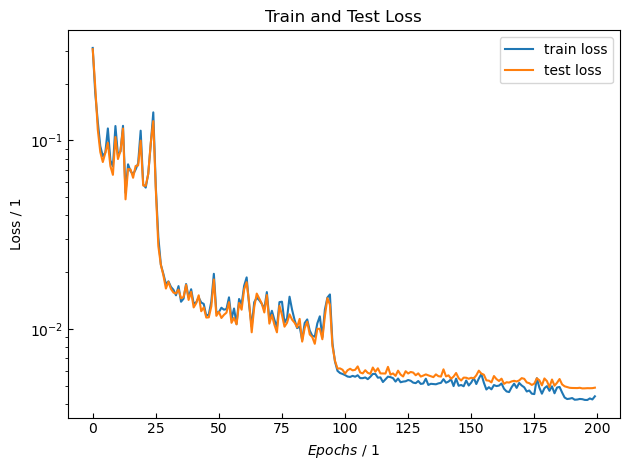

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9998863207529927 , R^2(NH3) = 0.9997070057981392
Test Dataset: R^2(H2) = 0.9999549537976322 , R^2(NH3) = 0.9998401428293894
Max Error Training: |x_H2 - x_H2,pred| = 0.04166722869785938 , |x_NH3 - x_NH3,pred| = 0.027194015341063638
Max Error Test: |x_H2 - x_H2,pred| = 0.0055224816963238 , |x_NH3 - x_NH3,pred| = 0.01280630960998072


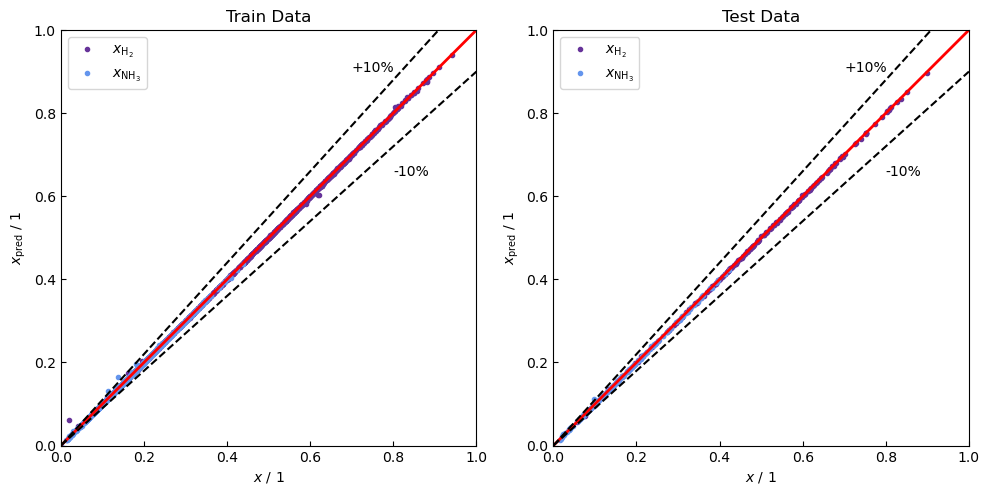

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

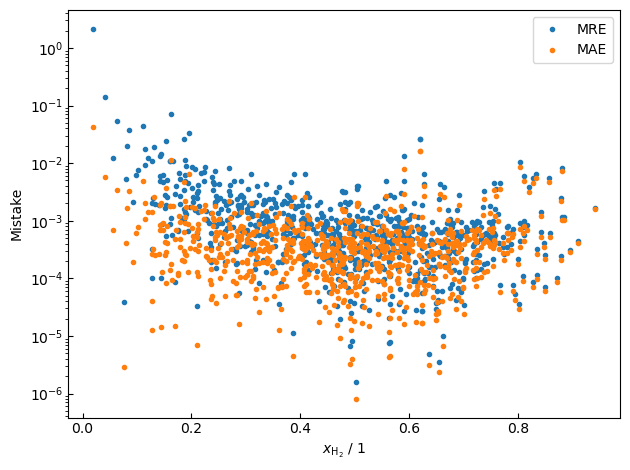

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

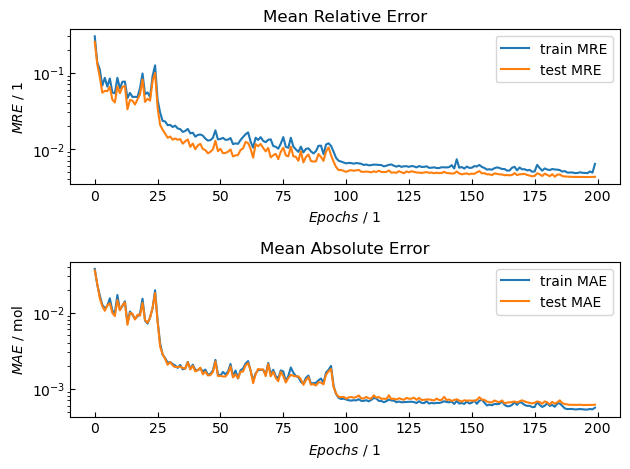

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

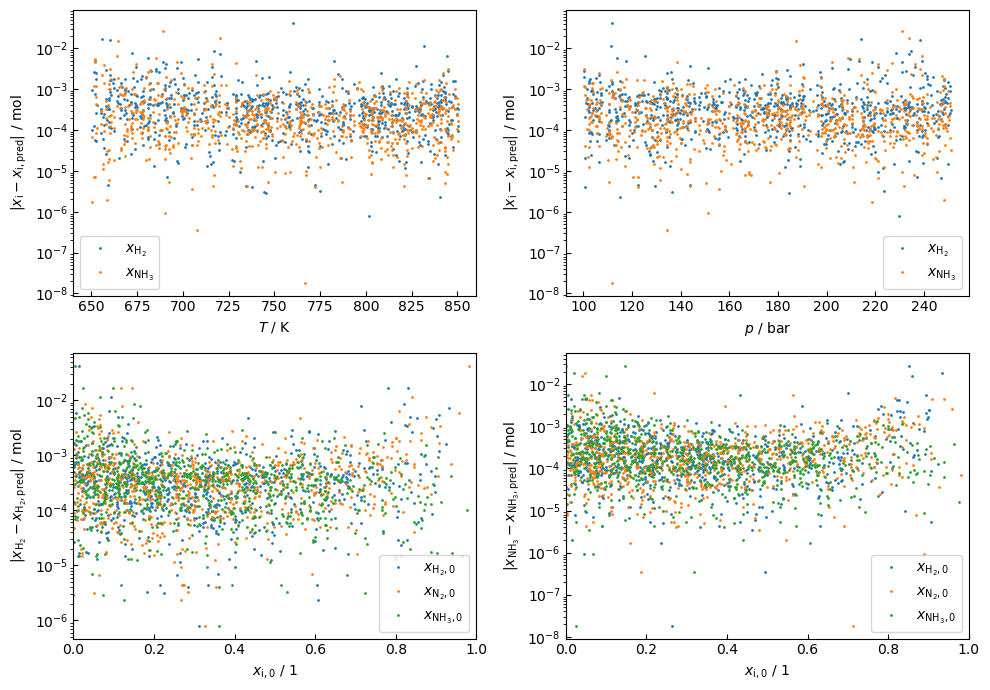

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

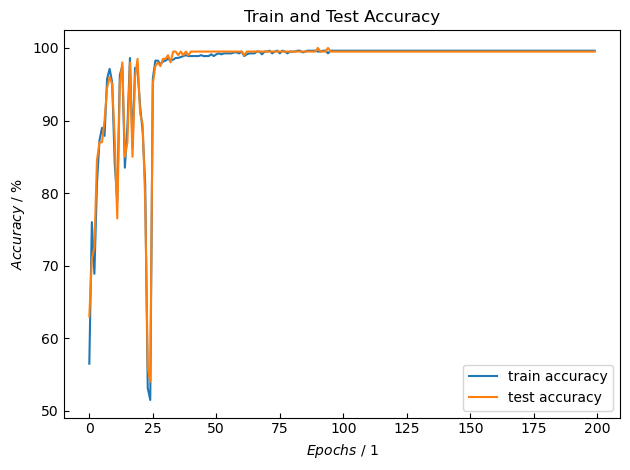

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [16]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-7.1554e-01, -9.1404e-01,  2.2415e-01,  6.0161e-01, -8.3487e-01],
        [ 9.1218e-01,  1.5642e+00, -1.1690e+00, -4.9312e-01,  1.6512e+00],
        [-6.3324e-01,  3.4146e-01, -5.1085e-01,  6.8952e-01, -2.0341e-01],
        [ 1.5014e-01, -4.7534e-01, -1.2199e+00,  4.5908e-01,  7.2801e-01],
        [-1.4235e+00,  5.8443e-01, -2.2827e-01,  4.0609e-01, -1.9104e-01],
        [ 4.1244e-02, -7.2939e-01,  1.4913e-01, -1.3058e-01, -1.2888e-02],
        [ 1.1448e+00,  2.3708e-02,  1.2820e+00, -8.4604e-01, -3.9344e-01],
        [ 7.5344e-01,  2.1125e-01, -5.0997e-01,  4.2557e-01,  6.5512e-02],
        [-1.4830e+00,  9.4015e-01, -3.4571e-03, -1.1798e+00,  1.2093e+00],
        [-7.7190e-01,  9.0307e-01, -1.6909e-02, -2.0957e-01,  2.3079e-01],
        [ 7.6037e-01,  1.4890e-01,  1.3659e+00, -2.1920e-01, -1.1164e+00],
        [-2.3655e-02,  1.3288e+00,  1.4785e-01, -1.1712e+00,  1.0520e+00],
        [ 1.1428e+00,  6.0827e-01,  3.7871e-02, -5.3177e-01,  5.0634e-01],
        [ 1.1604e+00, -3.

#### Einblick in Netzwerk

In [17]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-4.5551e-02,  1.1516e-01,  6.0585e-03, -1.2243e-01, -2.9168e-02],
         [-3.4728e-02,  1.4788e-03,  2.2419e-02,  5.5159e-02, -8.0197e-03],
         [ 1.1723e-01,  1.7371e-01, -1.1542e-01,  9.1207e-02,  9.8531e-02],
         [-5.6986e-02,  8.6158e-02, -1.8664e-02,  1.6472e-01,  8.8702e-02],
         [ 1.5269e-01, -2.6531e-02, -7.8976e-02, -3.6117e-01, -8.0074e-02],
         [ 2.6089e-01, -2.8096e-01, -1.1560e-03,  4.9590e-01,  1.4488e-01],
         [ 1.4676e-01, -1.8659e-01,  9.2232e-02,  2.3595e-01, -8.5296e-02],
         [-2.4108e-01,  2.2045e-01,  8.3303e-02, -3.1030e-02,  2.6836e-01],
         [-1.3770e-01, -2.4736e-04, -9.3965e-02,  2.8967e-01, -3.4477e-01],
         [-1.7938e-01, -2.3115e-01,  2.7542e-01, -2.2277e-01,  1.1175e-01],
         [ 2.7933e-01,  4.2273e-03, -4.8927e-02,  3.2154e-01, -4.4935e-02],
         [-3.5540e-03, -1.7222e-01,  1.9541e-01, -4.0080e-01, -1.8079e-01],
         [-4.3469e-01,  2.4776e-01,  2.0466e-01,  1.3178e-01, -2.

In [18]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.6310, 0.5346, 0.0110, 0.2387, 0.6927],
        [0.6583, 0.5175, 0.6927, 0.1344, 0.6184]])
tensor([[ 0.1155, -0.3447],
        [ 0.3907, -0.3379]], grad_fn=<AddmmBackward0>)


In [19]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [20]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 1.1170,  0.1261,  1.8675, -1.1061, -0.7023],
        [ 1.0805,  1.4381, -0.3820,  0.6188, -0.2576],
        [ 0.8855, -0.0247, -1.2081,  0.5008,  0.6737],
        [ 0.4569, -0.5525,  0.3056,  0.9533, -1.2742],
        [-0.2493,  0.7430,  0.3574,  0.0463, -0.3981],
        [-0.0896, -0.5045, -0.6923,  0.4943,  0.1742],
        [ 0.3820, -1.4799, -0.8625,  1.6130, -0.8021],
        [ 1.3538, -0.2770,  0.4574,  0.3898, -0.8474],
        [-1.2379,  0.0827,  1.6796, -0.9896, -0.6369],
        [-0.5486,  0.5752,  0.0650, -1.2773,  1.2417],
        [ 1.4278, -1.5541, -0.0272, -1.1204,  1.1718],
        [ 0.6114, -0.8434, -0.9004, -1.3014,  2.2137],
        [ 0.8425,  0.9485, -0.2239,  0.8750, -0.6746],
        [ 0.3445, -0.0847,  1.6464, -0.5924, -1.0103],
        [-0.8798, -0.6236,  1.1565, -0.4773, -0.6471],
        [ 0.3924, -1.5774,  0.1353, -0.6120,  0.4927],
        [-0.0369, -1.5949, -0.0789, -1.1470,  1.2498],
        [-1.1458,  0.1742,  1.3031,  0.0894, -1.3702],
        [ 

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()